Source: https://data.globalforestwatch.org/documents/941f17325a494ed78c4817f9bb20f33a/explore

Each year this should be updated.

In [1]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
from tile_mate.tile_model import TILE_SCHEMA
from tile_mate.stitcher import DATA_DIR
import pandera as pa
from dem_stitcher.geojson_io import to_geojson_gzip

# Generate tiles

We are going to use the Hansen et al. data found [here](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/download.html).

In [2]:
# box inputs are minx, miny, maxx, maxy
geometries = [box(-180 + i * 10, 
                  80 - (j + 1) * 10, 
                  -180 + (i + 1) * 10,
                  80 - (j) * 10) for i in range(36) for j in range(16)]

# Upper left corner
ul_corners = [(-180 + (i) * 10, 80 - (j) * 10) for i in range(36) for j in range(16)]
df_hansen_tiles = gpd.GeoDataFrame(geometry=geometries, crs=CRS.from_epsg(4326))

Let's see the tiles.

<Axes: >

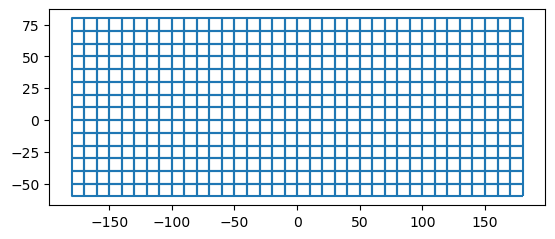

In [3]:
df_hansen_tiles.exterior.plot()

In [4]:
def url_generator(corner: tuple, 
                  layer: str ='last'):
    
    assert(layer in ['first', 'last', 'treecover2000'])
    
    base_url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10'
    lon, lat = corner
    if lon < 0:
        lon_str = f'{abs(lon):03d}W'
    else:
        lon_str = f'{abs(lon):03d}E'
    if lat >= 0:
        lat_str = f'{abs(lat):02d}N'
    else:
        lat_str = f'{abs(lat):02d}S'
    return f'{base_url}/Hansen_GFC-2022-v1.10_last_{lat_str}_{lon_str}.tif'

def tile_generator(corner: tuple):
    
    lon, lat = corner
    if lon < 0:
        lon_str = f'{abs(lon):03d}W'
    else:
        lon_str = f'{abs(lon):03d}E'
    if lat >= 0:
        lat_str = f'{abs(lat):02d}N'
    else:
        lat_str = f'{abs(lat):02d}S'
    return f'{lat_str}_{lon_str}'


In [5]:
df_hansen_tiles_last = df_hansen_tiles.copy()
df_hansen_tiles_last['url'] = list(map(url_generator, ul_corners))
#df_hansen_tiles_last['year'] = 2020
df_hansen_tiles_last['tile_id'] = list(map(tile_generator, ul_corners))
df_hansen_tiles_last.head()

,geometry,url,tile_id
0,"POLYGON ((-170.00000 70.00000, -170.00000 80.0...",https://storage.googleapis.com/earthenginepart...,80N_180W
1,"POLYGON ((-170.00000 60.00000, -170.00000 70.0...",https://storage.googleapis.com/earthenginepart...,70N_180W
2,"POLYGON ((-170.00000 50.00000, -170.00000 60.0...",https://storage.googleapis.com/earthenginepart...,60N_180W
3,"POLYGON ((-170.00000 40.00000, -170.00000 50.0...",https://storage.googleapis.com/earthenginepart...,50N_180W
4,"POLYGON ((-170.00000 30.00000, -170.00000 40.0...",https://storage.googleapis.com/earthenginepart...,40N_180W


Let's read the bounds from the URLs and make sure they match.

In [38]:
len('_last_00N_040W.tif')

18

In [35]:
k = 204
url = df_hansen_tiles_last.url.tolist()[k]
geo = df_hansen_tiles_last.geometry.tolist()[k]
with rasterio.open(url) as ds:
    b = ds.bounds
    print(b)
    print(url)
print(geo.bounds)
geo.contains(box(*ds.bounds).buffer(-.1))

BoundingBox(left=-40.0, bottom=-10.0, right=-30.0, top=0.0)
https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/Hansen_GFC-2022-v1.10_last_00N_040W.tif
(-40.0, -10.0, -30.0, 0.0)


True

In [36]:
df_hansen_tiles_last = TILE_SCHEMA.validate(df_hansen_tiles_last)

# Serialize

In [37]:
to_geojson_gzip(df_hansen_tiles_last, str(DATA_DIR / 'hansen_landsat_mosaic_2022.geojson.zip'))

'/Users/cmarshak/bekaert-team/tile-mate/tile_mate/data/hansen_landsat_mosaic_2022.geojson.zip'